In [8]:
import torch
from pytorch_lightning import LightningModule
from deepautoqc.models import TransfusionCBRCNN

class CheckpointedModel(TransfusionCBRCNN, LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

checkpoint_path = '/Users/Dominik/Charite/DeepAutoQC/src/deepautoqc/ckpts/2-636.ckpt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Assuming the labels were ['usable', 'unusable']
model = CheckpointedModel(model_name='small', labels=['usable', 'unusable'])
# Remove 'model.' prefix in the checkpoint keys
state_dict = {k.replace('model.', ''): v for k, v in checkpoint['state_dict'].items()}

# Load the modified state_dict into the model
model.load_state_dict(state_dict)

#model.load_state_dict(checkpoint['state_dict'])
model.eval()  # set the model in evaluation mode


CheckpointedModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (global_pool): Sequential(
    (

In [17]:
model.features[14]

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [9]:
import numpy as np
from torchvision.transforms import functional as F
from deepautoqc.utils import load_from_pickle
from deepautoqc.data_structures import BrainScan

# Assuming test_img is a numpy array of shape (690, 551, 3)
# Reshape to (3, 690, 551) and normalize to [0, 1] range
#test_img = test_img.transpose((2, 0, 1)) / 255.0

pkl_path = '/Volumes/PortableSSD/data/skullstrip_rpt_processed_usable/_sub-102008_report-skull.pkl'

subjects_data = load_from_pickle(pkl_path)
test_img = subjects_data[1].img

test_img = test_img.transpose((2, 0, 1))

# Add an extra dimension to simulate the batch size of 1
test_img = np.expand_dims(test_img, axis=0)

# Convert to tensor
test_img = torch.tensor(test_img, dtype=torch.float32)


In [10]:
# Forward pass through the model
with torch.no_grad():  # no need to calculate gradients during inference
    intermediate_features = model(test_img, features=True)


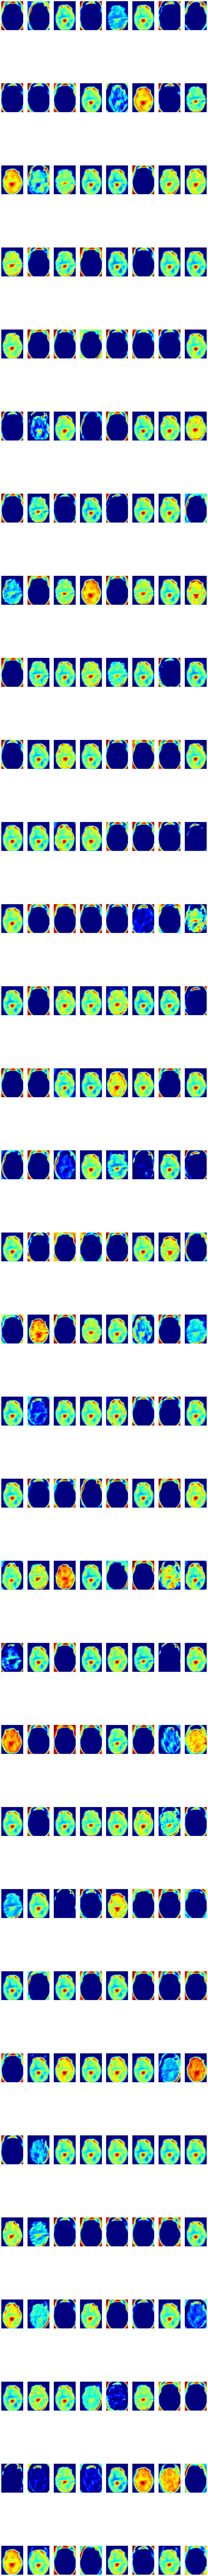

In [21]:
import matplotlib.pyplot as plt

# For visualization, pick one feature map from the batch and convert tensor to numpy array
feature_map_to_visualize = intermediate_features[0].numpy()

# Plot all feature maps in a grid
num_feature_maps = feature_map_to_visualize.shape[0]

fig, axs = plt.subplots(nrows=num_feature_maps//8, ncols=8, figsize=(20, num_feature_maps))

for i, ax in enumerate(axs.flat):
    ax.imshow(feature_map_to_visualize[i], cmap='jet')
    ax.axis('off')
plt.show()


In [12]:
with torch.no_grad():
    final_predictions = model(test_img, features=False)


In [13]:
print(final_predictions)

tensor([[0.0946, 2.2593]])
